In [2]:
# Base Model
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return residual + out

class Generator(nn.Module):
    def __init__(self, num_res_blocks=5, num_channels=64):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.middle = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_channels)
        )
        self.upsample_blocks = nn.Sequential(
            nn.Conv2d(num_channels, num_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(num_channels, num_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.final = nn.Conv2d(num_channels, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.initial(x)
        residual = x
        x = self.res_blocks(x)
        x = self.middle(x) + residual
        x = self.upsample_blocks(x)
        x = self.final(x)
        print(x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        features = [64, 128, 256, 512]
        layers = []
        for i in range(1, len(features)):
            layers.append(nn.Conv2d(features[i-1], features[i], kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(features[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(features[i], features[i], kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(features[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.middle = nn.Sequential(*layers)
        self.final = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.middle(x)
        x = self.final(x)
        return x


In [3]:

from PIL import Image
from torchvision import transforms

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image


torch.Size([1, 3, 384, 384])


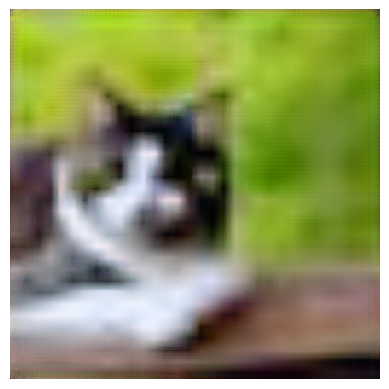

In [6]:
import torch
from torchvision import transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from PIL import Image

# Load the checkpoint and setup the generator
checkpoint = torch.load(r'C:\Users\juver\Untitled Folder 1\model_checkpoint2.pth', map_location='cpu')
generator = Generator()
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# Define the path to your low-resolution image
image_path = 'C:/Users/juver/Downloads/1000 (4).jpg'   # Make sure the path is correct

# Transform pipeline for the image
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to the input size expected by your model
    transforms.ToTensor()         # Convert image to a PyTorch tensor
])

# Load the image, apply the transform, and ensure correct dimensionality
lr_image = Image.open(image_path).convert('RGB')
lr_image = transform(lr_image)
lr_image = lr_image.unsqueeze(0)  # Add a batch dimension if not already present

# Move the image tensor to the correct device
device = torch.device('cpu')  # Or 'cuda' if you are using GPU
lr_image = lr_image.to(device)

# Generate high-resolution image
with torch.no_grad():
    hr_image = generator(lr_image)  # No need to unsqueeze if already done

# Normalize and convert to PIL for display and saving
hr_image = hr_image.squeeze(0)  # Remove batch dimension
hr_image = torch.clamp(hr_image, 0, 1)  # Clamp values to valid image range
to_pil = ToPILImage()
hr_image_pil = to_pil(hr_image.cpu())  # Convert to CPU if necessary

# Display the image
plt.imshow(hr_image_pil)
plt.axis('off')  # Hide axes
plt.show()

# Optionally, save the image if needed
# hr_image_pil.save('C:/path/to/save/high-resolution/output_image.png')


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import resize
from datasets import load_dataset

class Div2kValidationDataset(Dataset):
    def _init_(self, div2k_data, transform=None, target_size=(384, 384)):
        self.div2k_data = div2k_data
        self.transform = transform
        self.target_size = target_size

    def _len_(self):
        return len(self.div2k_data)

    def _getitem_(self, idx):
        lr_image_path = self.div2k_data[idx]['lr']
        hr_image_path = self.div2k_data[idx]['hr']
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')
        
        # Resize HR image using PIL for better quality control
        hr_image = hr_image.resize(self.target_size, Image.BICUBIC)
        
        if self.transform:
            lr_image = self.transform(lr_image)
        
        # Convert HR image to tensor
        hr_image = transforms.ToTensor()(hr_image)
        
        return lr_image, hr_image

# Load the dataset
div2k_validation_dataset = load_dataset("eugenesiow/Div2k", split='validation[:100]')
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Low-resolution images resized for model input
    transforms.ToTensor()
])
validation_dataset = Div2kValidationDataset(div2k_validation_dataset, transform=transform, target_size=(384, 384))
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

# Assume Generator is defined elsewhere and correctly imported
# Load the model from a checkpoint
device = torch.device('cpu')  # Adjust as necessary for your setup
checkpoint = torch.load(r'C:\Users\juver\Untitled Folder 1\model_checkpoint2.pth', map_location=device)
generator = Generator().to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# Evaluate
psnrs = []
ssims = []
for lr_image, hr_image_true in validation_loader:
    lr_image = lr_image.to(device)
    hr_image_true = hr_image_true.to(device)  # HR image already resized and converted in _getitem_
    
    with torch.no_grad():
        hr_image_pred = generator(lr_image)
        hr_image_pred = hr_image_pred.clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy()
        hr_image_true = hr_image_true.permute(0, 2, 3, 1).cpu().numpy()

    # Ensure images are in the correct format and scale
    hr_image_pred = (hr_image_pred * 255).astype(np.uint8)
    hr_image_true = (hr_image_true * 255).astype(np.uint8)

    # Calculate metrics for each image in the batch
    for true, pred in zip(hr_image_true, hr_image_pred):
        psnr = peak_signal_noise_ratio(true, pred, data_range=255)
        ssim = structural_similarity(true, pred, multichannel=True, data_range=255)
        psnrs.append(psnr)
        ssims.append(ssim)

# Calculate and print average metrics
print(f"Average PSNR: {np.mean(psnrs):.2f}")
print(f"Average SSIM: {np.mean(ssims):.4f}")
print(f"Max PSNR: {np.max(psnrs):.2f}")
print(f"Max SSIM: {np.max(ssims):.4f}")

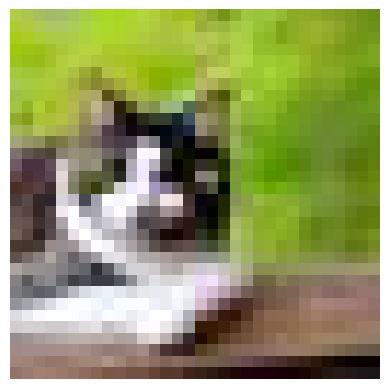

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path = 'C:/Users/juver/Downloads/1000 (4).jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


In [8]:
# Final  Model
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return residual + out

class Generator(nn.Module):
    def __init__(self, num_res_blocks=8, num_channels=64):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.middle = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_channels)
        )
        self.upsample_blocks = nn.Sequential(
            nn.Conv2d(num_channels, num_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(num_channels, num_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.final = nn.Conv2d(num_channels, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.initial(x)
        residual = x
        x = self.res_blocks(x)
        x = self.middle(x) + residual
        x = self.upsample_blocks(x)
        x = self.final(x)
        return x

class DiscriminatorGlobal(nn.Module):
    def __init__(self):
        super(DiscriminatorGlobal, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        features = [64, 128, 256, 512]
        layers = []
        for i in range(1, len(features)):
            layers.append(nn.Conv2d(features[i-1], features[i], kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(features[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(features[i], features[i], kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(features[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.middle = nn.Sequential(*layers)
        self.final = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.middle(x)
        x = self.final(x)
        return x

class DiscriminatorLocal(nn.Module):
    def __init__(self):
        super(DiscriminatorLocal, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.final = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.final(x)
        return x


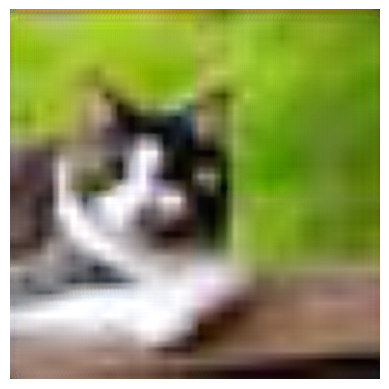

In [10]:
import torch
from torchvision import transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from PIL import Image

# Load the checkpoint and setup the generator
checkpoint = torch.load(r'C:\Users\juver\Untitled Folder 1\model_checkpoint3.pth', map_location='cpu')
generator = Generator()
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# Define the path to your low-resolution image
image_path = 'C:/Users/juver/Downloads/1000 (4).jpg'   # Make sure the path is correct

# Transform pipeline for the image
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to the input size expected by your model
    transforms.ToTensor()         # Convert image to a PyTorch tensor
])

# Load the image, apply the transform, and ensure correct dimensionality
lr_image = Image.open(image_path).convert('RGB')
lr_image = transform(lr_image)
lr_image = lr_image.unsqueeze(0)  # Add a batch dimension if not already present

# Move the image tensor to the correct device
device = torch.device('cpu')  # Or 'cuda' if you are using GPU
lr_image = lr_image.to(device)

# Generate high-resolution image
with torch.no_grad():
    hr_image = generator(lr_image)  # No need to unsqueeze if already done

# Normalize and convert to PIL for display and saving
hr_image = hr_image.squeeze(0)  # Remove batch dimension
hr_image = torch.clamp(hr_image, 0, 1)  # Clamp values to valid image range
to_pil = ToPILImage()
hr_image_pil = to_pil(hr_image.cpu())  # Convert to CPU if necessary

# Display the image
plt.imshow(hr_image_pil)
plt.axis('off')  # Hide axes
plt.show()

# Optionally, save the image if needed
# hr_image_pil.save('C:/path/to/save/high-resolution/output_image.png')


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import resize
from datasets import load_dataset

class Div2kValidationDataset(Dataset):
    def _init_(self, div2k_data, transform=None, target_size=(384, 384)):
        self.div2k_data = div2k_data
        self.transform = transform
        self.target_size = target_size

    def _len_(self):
        return len(self.div2k_data)

    def _getitem_(self, idx):
        lr_image_path = self.div2k_data[idx]['lr']
        hr_image_path = self.div2k_data[idx]['hr']
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')
        
        # Resize HR image using PIL for better quality control
        hr_image = hr_image.resize(self.target_size, Image.BICUBIC)
        
        if self.transform:
            lr_image = self.transform(lr_image)
        
        # Convert HR image to tensor
        hr_image = transforms.ToTensor()(hr_image)
        
        return lr_image, hr_image

# Load the dataset
div2k_validation_dataset = load_dataset("eugenesiow/Div2k", split='validation[:100]')
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Low-resolution images resized for model input
    transforms.ToTensor()
])
validation_dataset = Div2kValidationDataset(div2k_validation_dataset, transform=transform, target_size=(384, 384))
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

# Assume Generator is defined elsewhere and correctly imported
# Load the model from a checkpoint
device = torch.device('cpu')  # Adjust as necessary for your setup
checkpoint = torch.load(r'C:\Users\juver\Untitled Folder 1\model_checkpoint3.pth', map_location=device)
generator = Generator().to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# Evaluate
psnrs = []
ssims = []
for lr_image, hr_image_true in validation_loader:
    lr_image = lr_image.to(device)
    hr_image_true = hr_image_true.to(device)  # HR image already resized and converted in _getitem_
    
    with torch.no_grad():
        hr_image_pred = generator(lr_image)
        hr_image_pred = hr_image_pred.clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy()
        hr_image_true = hr_image_true.permute(0, 2, 3, 1).cpu().numpy()

    # Ensure images are in the correct format and scale
    hr_image_pred = (hr_image_pred * 255).astype(np.uint8)
    hr_image_true = (hr_image_true * 255).astype(np.uint8)

    # Calculate metrics for each image in the batch
    for true, pred in zip(hr_image_true, hr_image_pred):
        psnr = peak_signal_noise_ratio(true, pred, data_range=255)
        ssim = structural_similarity(true, pred, multichannel=True, data_range=255)
        psnrs.append(psnr)
        ssims.append(ssim)

# Calculate and print average metrics
print(f"Average PSNR: {np.mean(psnrs):.2f}")
print(f"Average SSIM: {np.mean(ssims):.4f}")
print(f"Max PSNR: {np.max(psnrs):.2f}")
print(f"Max SSIM: {np.max(ssims):.4f}")